# 3D MNIST
This is meant as an exercise in 3D CNNs

In [1]:
import tensorflow as tf

import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path
from time import strftime
import h5py

import tensorboard

In [2]:
def get_run_logdir(root_logdir = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/messing around/tensorboard_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [3]:
# -- Preparatory code --
# Model configuration
batch_size = 100
no_epochs = 100 # previously 30
learning_rate = 0.001
no_classes = 10
validation_split = 0.2
verbosity = 1

In [4]:
path_to_saved = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/messing around/3dmnist_model")

path_to_fulldata = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/messing around/3D_MNIST/full_dataset_vectors.h5")

In [5]:
# Convert 1D vector into 3D values, provided by the 3D MNIST authors at
# https://www.kaggle.com/daavoo/3d-mnist
def array_to_color(array, cmap="Oranges"):
  s_m = plt.cm.ScalarMappable(cmap=cmap)
  return s_m.to_rgba(array)[:,:-1]

# Reshape data into format that can be handled by Conv3D layers.
# Courtesy of Sam Berglin; Zheming Lian; Jiahui Jang - University of Wisconsin-Madison
# Report - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/Report.pdf
# Code - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/network_final_version.ipynb
def rgb_data_transform(data):
  data_t = []
  for i in range(data.shape[0]):
    data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
  return np.asarray(data_t, dtype=np.float32)

In [6]:
# -- Process code --
# Load the HDF5 data file
with h5py.File(path_to_fulldata, "r") as hf:

    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    targets_test = hf["y_test"][:]

    # Determine sample shape
    sample_shape = (16, 16, 16, 3)

    # Reshape data into 3D format
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)

    # Convert target vectors to categorical targets
    targets_train = tf.keras.utils.to_categorical(targets_train).astype(np.int64) # formerly: np.integer
    targets_test = tf.keras.utils.to_categorical(targets_test).astype(np.int64) # formerly: np.integer

In [7]:
# Create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

In [8]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 14, 14, 32)    2624      
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 7, 7, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 7, 7, 32)       0         
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 5, 5, 64)       55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 2, 2, 64)       0         
 g3D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 2, 64)       0

In [9]:
path_to_callback = os.path.join(path_to_saved, "my_checkpoint")

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath = path_to_callback,
                                                   monitor = "val_accuracy",
                                                   mode = "max",
                                                   save_best_only = True,
                                                   save_weights_only = True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights = True)

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = run_logdir,
                                                histogram_freq = 1)

In [10]:
# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

# Fit data to model
history = model.fit(X_train, targets_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split,
            callbacks = [checkpoint_cb, early_stopping_cb, tensorboard_cb])

model.save(path_to_saved / "3d_mnist_model", save_format="tf")

Epoch 1/100
80/80 [==============================] - 18s 226ms/step - loss: 2.5594 - accuracy: 0.0990 - val_loss: 2.3010 - val_accuracy: 0.1170
Epoch 2/100
80/80 [==============================] - 18s 222ms/step - loss: 2.2997 - accuracy: 0.1114 - val_loss: 2.3012 - val_accuracy: 0.1050
Epoch 3/100
80/80 [==============================] - 18s 222ms/step - loss: 2.3007 - accuracy: 0.1100 - val_loss: 2.2981 - val_accuracy: 0.1210
Epoch 4/100
80/80 [==============================] - 18s 227ms/step - loss: 2.2745 - accuracy: 0.1404 - val_loss: 2.2777 - val_accuracy: 0.1425
Epoch 5/100
80/80 [==============================] - 18s 225ms/step - loss: 2.2335 - accuracy: 0.1665 - val_loss: 2.2077 - val_accuracy: 0.2290
Epoch 6/100
80/80 [==============================] - 18s 231ms/step - loss: 2.1802 - accuracy: 0.1971 - val_loss: 2.1588 - val_accuracy: 0.2450
Epoch 7/100
80/80 [==============================] - 18s 229ms/step - loss: 2.1250 - accuracy: 0.2236 - val_loss: 2.1221 - val_accuracy:

KeyboardInterrupt: 

Test loss: 1.0306199789047241 / Test accuracy: 0.640999972820282


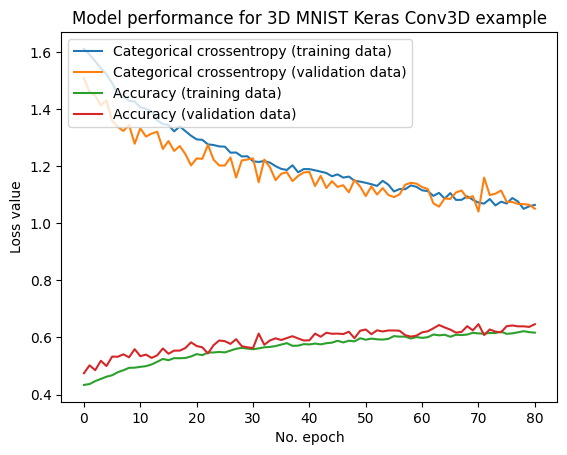

In [24]:
# Generate generalization metrics
score = model.evaluate(X_test, targets_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()